# HSE 2021: Mathematical Methods for Data Analysis
# Luckyanchuk Bogdan BSE-213
## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand. 

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [137]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if not y.shape[0]:
        return 0.0
    mean_y = y.mean()
    impur_array = np.absolute(y - mean_y)
    impurity = np.sum(impur_array)/(impur_array).shape[0]
    return impurity

In [138]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [198]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    x_column = X[:, j]
    r_left = y[x_column <= t]
    r_right = y[x_column > t]
    Q = (r_left).shape[0]/(y).shape[0]*H(r_left) + \
        (r_right).shape[0]/(y).shape[0]*H(r_right)
    return Q

Реализация взята с семинара №7

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [134]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """

    def __init__(self, depth = 1, pred = 1):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = depth
        self.is_terminal = False
        self.prediction = pred

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
                format(self.column, self.threshold, self.prediction)
        return node_desc

In [224]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """

    def __init__(self, max_depth=6, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """
        #print("новый")
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)

        for feature_num in range(X.shape[1]):
            feature_column = X[:, feature_num]

            for split_x in range(0, len(feature_column)):
                y_right = y[feature_column > feature_column[split_x]]
                y_left = y[feature_column <= feature_column[split_x]]

                if len(y_right) == 0 or len(y_left) == 0:
                    continue

                new_Q = Q(X, y, feature_num, feature_column[split_x])
                if new_Q <= best_cost:
                    #print('старое {:.5f}'.format(best_cost))
                    #print('новое {:.5f}'.format(new_Q))
                    best_cost = new_Q
                    best_split_column = feature_num
                    best_threshold = feature_column[split_x]

        if best_cost == H(y):
            return None, None, None, None, None, None

        best_col = X[:, best_split_column]
        X_left = X[best_col <= best_threshold, :]
        y_left = y[best_col <= best_threshold]
        X_right = X[best_col > best_threshold, :]
        y_right = y[best_col > best_threshold]
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal = True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(
            X, y)

        if best_split_column is None:
            node.is_terminal = True
            return

        if X_left.shape[0] < self.min_samples_leaf or X_right.shape[0] < self.min_samples_leaf:
            node.is_terminal = True
            return

        node.column = best_split_column
        node.threshold = best_threshold

        # инициализация детей
        node.left = Node(node.depth+1,  np.mean(y_left))
        node.right = Node(node.depth+1,  np.mean(y_right))

        # рекурсивный взов далее
        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        # Initialize the tree (root node)
        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)

        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal == True:
            return node.prediction
        if x[node.column] > node.threshold:
            y_pred = self.get_prediction(node.right, x)
        else:
            y_pred = self.get_prediction(node.left, x)
        return y_pred

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

Код для данного класса взят из реализации DecisionTreeClassifier_from_scratch семинара №7

In [226]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

In [266]:
data = pd.read_pickle("boston.pkl")
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Train 2.963004849928892
Test 3.2195979088679483
[Text(0.5, 0.875, 'RM <= 6.941\nsquared_error = 88.682\nsamples = 379\nvalue = 22.908'), Text(0.25, 0.625, 'LSTAT <= 14.4\nsquared_error = 40.363\nsamples = 314\nvalue = 19.954'), Text(0.125, 0.375, 'DIS <= 1.385\nsquared_error = 26.28\nsamples = 187\nvalue = 23.394'), Text(0.0625, 0.125, 'squared_error = 91.577\nsamples = 4\nvalue = 44.475'), Text(0.1875, 0.125, 'squared_error = 14.927\nsamples = 183\nvalue = 22.933'), Text(0.375, 0.375, 'CRIM <= 7.084\nsquared_error = 18.04\nsamples = 127\nvalue = 14.891'), Text(0.3125, 0.125, 'squared_error = 10.405\nsamples = 75\nvalue = 17.104'), Text(0.4375, 0.125, 'squared_error = 11.794\nsamples = 52\nvalue = 11.698'), Text(0.75, 0.625, 'RM <= 7.437\nsquared_error = 76.4\nsamples = 65\nvalue = 37.175'), Text(0.625, 0.375, 'LSTAT <= 15.765\nsquared_error = 39.248\nsamples = 40\nvalue = 32.382'), Text(0.5625, 0.125, 'squared_error = 22.076\nsamples = 38\nvalue = 33.345'), Text(0.6875, 0.125, 'square

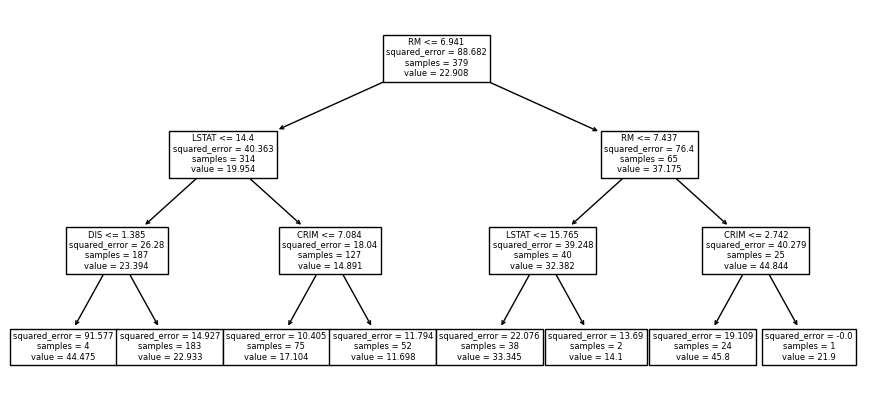

In [285]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import graphviz

from sklearn import tree
#X = df
#y = pd.DataFrame(data.target, columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(df, data.target, \
                                                    test_size=0.25, random_state=42)

#custom_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=2)
custom_tree = tree.DecisionTreeRegressor(max_depth=3,min_samples_split=2, min_samples_leaf=1)
custom_tree.fit(X_train, y_train)
pred_test = custom_tree.predict(X_test)
pred_train = custom_tree.predict(X_train)

print("Train",mean_absolute_error(y_train,pred_train))
print("Test",mean_absolute_error(y_test,pred_test))

print(tree.plot_tree(custom_tree,feature_names = data.feature_names))


### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `MAE` on test dataset and hyperparameters of the best estimator. 

In [287]:
from sklearn.model_selection import GridSearchCV
params_custom_tree =  {'max_depth':np.linspace(1,1000,20,dtype=int) ,'min_samples_leaf': np.linspace(1,500,20,dtype=int)}
custom_tree_grid = GridSearchCV(MyDecisionTreeRegressor(), params_custom_tree, scoring = 'neg_mean_absolute_error', cv=5)
custom_tree_grid.fit(X_train, y_train)
print('Best parameters: ', custom_tree_grid.best_params_)


Best parameters:  {'max_depth': 53, 'min_samples_leaf': 1}


In [290]:
custom_tree_best_params = MyDecisionTreeRegressor(max_depth=53, min_samples_leaf=1)
custom_tree_best_params.fit(X_train, y_train)
pred = custom_tree_best_params.predict(X_test)

print("Test MAE",mean_absolute_error(y_test,pred))

Test MAE 3.3047244094488186


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [429]:
def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in
    Returns
    -------
    bias2 : float,
        Estiamted squared bias
    variance : float,
        Estiamted variance
    """
    bias2, variance = 0,0
    pred = np.ones((n_iter,x.shape[0])) * np.nan
    for x_i in range(n_iter):
        x_indexes = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        oob_indexes = np.delete(np.arange(x.shape[0]),np.unique(x_indexes))
        estimator.fit(x[x_indexes],y[x_indexes])
        pred[x_i][oob_indexes] = estimator.predict(x[oob_indexes])
    pred_mean = np.nanmean(pred,axis=0)
    variance = np.nanmean((pred-pred_mean)**2)
    bias2 = np.nanmean((pred_mean - y)**2)
    return bias2, variance

In [434]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train, 30)

(18.755308600088203, 9.013486640844079)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases. 

Comment on what you observe, how does your result correspond to theory?

In [457]:
bias_var_result = []
min_sample_split_range = np.linspace(1,1000,20,dtype=int)
for min_sample_split in min_sample_split_range:
    estimator = MyDecisionTreeRegressor(max_depth=20, min_samples_split=min_sample_split)
    bias_var_result.append(get_bias_variance(estimator, X_train.values, y_train, 100))


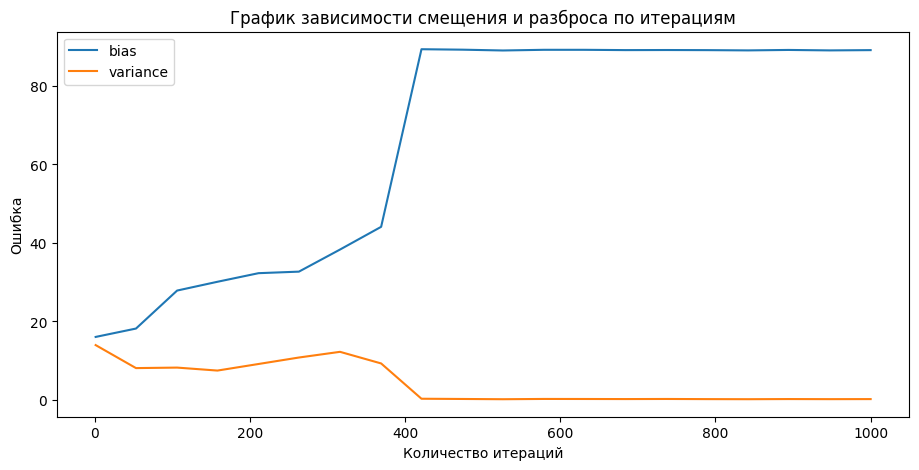

In [458]:
plt.figure()
plt.plot(min_sample_split_range,bias_var_result,label=["bias","variance"])
plt.xlabel('Количество итераций')
plt.ylabel('Ошибка')
plt.title('График зависимости смещения и разброса по итерациям')
plt.legend()
plt.show()


``` your comments here```

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [461]:
from sklearn.ensemble import BaggingRegressor
bagging_model = BaggingRegressor(MyDecisionTreeRegressor(max_depth=60))
tree_model = MyDecisionTreeRegressor(max_depth=60)

bagging_model_bias,bagging_model_var = get_bias_variance(bagging_model, X_train.values, y_train, 100)
tree_model_bias,tree_model_var = get_bias_variance(tree_model, X_train.values, y_train, 100)

print(f'Bagging model results: bias = {bagging_model_bias}, variance = {bagging_model_var}')
print(f'Tree model results: bias = {tree_model_bias}, variance = {tree_model_var}')


Bagging model results: bias = 15.319814854361162, variance = 3.3590364185286274
Tree model results: bias = 16.016981866107464, variance = 14.02922215215618


```your comments here```

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task. 

In [291]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset. 

In [459]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   personName                                  2640 non-null   object 
 4   age                                         2575 non-null   float64
 5   country                                     2602 non-null   object 
 6   city                                        2568 non-null   object 
 7   source                                      2640 non-null   object 
 8   industries                                  2640 non-null   object 
 9   countryOfCitizenship                        2640 non-null   object 
 10  organization

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# YOUR CODE HERE
# define column_transformer

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train. 

In [ ]:
# YOUR CODE HERE